# Parspec Data Science Interview Assignment

In [1]:
# Import required libraries
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

### Read the train/test datasets

In [2]:
train = pd.read_csv('/content/drive/MyDrive/parspec_train_data.csv')
test = pd.read_csv('/content/drive/MyDrive/parspec_test_data.csv')
train.head()

,ID,URL,Is lighting product?
0,P-0,https://a4b6eb24-cef6-4be0-88b1-aa225dd7e4f7.u...,Yes
1,P-1,https://a4b6eb24-cef6-4be0-88b1-aa225dd7e4f7.u...,Yes
2,P-2,https://myelektralite.com/assets/1018-AI-Outdo...,Yes
3,P-3,https://myelektralite.com/assets/1018-Data-She...,Yes
4,P-4,https://myelektralite.com/assets/1018AI-Data-S...,Yes


In [3]:
print('Train rows:',train.shape[0])
print('Test rows:',test.shape[0])

Train rows: 1013
Test rows: 80


In [26]:
train['Is lighting product?'].value_counts()

Yes    500
No     500
Name: Is lighting product?, dtype: int64

*13 Missing values exist in train data*

In [62]:
test['Is lighting product?'].value_counts()

0    60
1    20
Name: Is lighting product?, dtype: int64

### Extraxt raw texts from the given pdf URL handles

In [3]:
!pip install PyMuPDF


Create function that extracts texts from individual pdf url

In [34]:
import requests
import fitz  # PyMuPDF

def extract_text_from_pdf_url(pdf_url):

    """
    pdf_url: string (URL handle)
    output: string (extracted text / 'Error')
    1. Inputs a pdf URL handle
    2. Checks status of webpage
    3. If pdf file exists, returns the extracted text
    4. Else return a failure message- 'Error'
    """

    # Download the PDF content from the URL
    response = requests.get(pdf_url, verify=False)

    # Check if the request was successful (status code 200)
    if response.status_code == 200:
        # Create a PyMuPDF document object from the PDF content
        pdf_document = fitz.open(stream=response.content, filetype="pdf")

        # Iterate through pages and extract text
        text = ""
        for page_number in range(pdf_document.page_count):
            page = pdf_document[page_number]
            text += page.get_text()

        # Close the PyMuPDF document
        pdf_document.close()

        if text == "":
          return "Error"
        else:
          return text
    else:
        # Print an error message if the request was not successful
        return "Error"


In [6]:
# Example usage 1
pdf_url = train['URL'][1]
extracted_text1 = extract_text_from_pdf_url(pdf_url)
print(extracted_text1)

Recommended Use:
•Architectural
•Landscaping
•General exterior lighting of
hotels, signs, flags, multi-unit
residential, commercial, and
government buildings.
24 led up light
DU-SQ-HW24
DETAILS
LIGHT SOURCE 
24x Cree 1 W LED Lamps
POWER CONSUMPTION 
32W
BEAM WIDTH
25 Degree
MEASUREMENT 
9-3/4”L x 7-3/4”W x 4-1/2”H
WEIGHT
17 Lbs
12 led DOWNlight
DU-SQ-HW12
*Includes DU-WS12 (Sconce)
DETAILS
LIGHT SOURCE 
12x1 W Cree LED Lamps
POWER CONSUMPTION 
13W
BEAM WIDTH
15 Degree
MEASUREMENT 
7-3/4”L x 6”W x 4-1/4”H
WEIGHT
13 Lbs
©Decors USA LLC
Phone: 866.248.6300 | 732.486.8520 | www.decorsusa.com | sales@decorsusa.com
Mount for 12 LED Downlight and 24 LED UP Light
DECORS Hallmark LED LIGHTS
DETAILS
MEASUREMENT 
10”W x 12”H x 5”D
WEIGHT
8 Lbs
• All-weather outdoor use
• IP65 rated.
• Environmental Temp. Range: -
7.6° to 113° F (-20° to 45° C)
• Electrical Input:  90-265VAC
• LED UP Light comes with
Mounting Brackets
hallmark
LED LIGHTS
SCONCE COVERS
DU-WS12 & DU-WS24
Decors USA Provides the UL L

In [7]:
# Example usage 2
pdf_url = train['URL'][2]
extracted_text2 = extract_text_from_pdf_url(pdf_url)
print(extracted_text2)

Error


Create function that extracts texts of all pdf urls present in dataset and stores it in a new column of the dataframe

In [5]:
def text_extractor(dataset):
  """
  dataset: csv file (train/test)
  output: dataset with an extra column 'Raw text' containing the extracted texts of individual pdf
  """
  extracted_texts = []
  for pdf_url in dataset['URL']:
    text = extract_text_from_pdf_url(pdf_url)
    extracted_texts.append(text)
  dataset['Raw text'] = extracted_texts
  return dataset

### Clean and tokenize the texts

In [7]:
!pip install nltk


In [6]:
import re
import string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

lemmatizer = WordNetLemmatizer()

def clean_and_tokenize(text):

    """
    text: str -> extracted text
    Cleans the raw text of special symbols/emails/hashtags/bullets etc.
    """

    # Remove URL handles (e.g., @username)
    text = re.sub(r'@\S+', '', text)
    # Remove email addresses
    text = re.sub(r'\S+@\S+', '', text)
    # Remove website addresses
    text = re.sub(r'www.\S+', '', text)
    # Remove hashtags
    text = re.sub(r'#\S+', '', text)
    # Remove bullet points
    text = re.sub(r'\s*[\u2022\u2023\u25E6]\s*', ' ', text)
    # Remove punctuation and digits
    text = re.sub(f"[{string.punctuation}\d]", "", text)
    # Remove other special symbols
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Convert to lowercase
    text = text.lower()
    # Tokenize the text
    tokens = word_tokenize(text)
    # Remove stop words
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    # Lemmatize tokens
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]
    # Remove single/double characters
    lemmatized_tokens = [word for word in lemmatized_tokens if len(word)>2]

    return ' '.join(list(set(lemmatized_tokens)))


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [30]:
tokens = clean_and_tokenize(extracted_text1)
print(tokens)

illumination red landscaping damage ducrcwxp led sign use light wiring level weight cover llc based distance consumption general decor duws environmental length opening done multiunit flag hotel mounting warranty attempt need location two single please listed junction volt installation unit alloy width blue wall total around rating photo seal supply input data measurement beam screw tight anchor drill performance four life silver recommended surface cool downlight marked detail source architectural lamp power disconnect connection commercial frequency install higher ground weather electrician lumen one come mount cable hole caution allweather note cree open efficiency box sensor bracket projection outlet serving water treatment connector government lighting angle parameter electrical amber shall wave available output etl temp mark various guide licensed effect connect controlled number included includ green exterior residential extended outdoor installed white aluminum appropriate prov

Create function that cleans all extracted texts and stores it in a new column in the dataframe

In [7]:
def clean_extracted_texts(dataset):
  """
  dataset: pd.DataFrame -> train/test
  Clean the extracted test for all rows in the train/test datasets and store it in column 'Clean text'
  """
  cleaned_texts = []
  for text in list(dataset['Raw text']):
    cleaned_texts.append(clean_and_tokenize(text))
  dataset['Clean text'] = cleaned_texts
  return dataset

### Stitching the preprocessing techniques above together to generate (X,y)-train & (X,y)-test

In [38]:
def preprocessing(train, test):

  # Drop rows containing missing values
  train = train.dropna(axis=0, how='any').reset_index(drop=True)
  test = test.dropna(axis=0, how='any').reset_index(drop=True)
  # Replace target labels Yes/No with 1/0
  train['Is lighting product?'] = train['Is lighting product?'].replace({'Yes':1, 'No':0})
  # Extract texts from pdf
  train1, test1 = text_extractor(train), text_extractor(test)
  # Drop rows having "Error" message (couldn't extract texts)
  train1 = train1[~train1['Raw text'].isin(["Error",""])].reset_index(drop=True)
  test1 = test1[~test1['Raw text'].isin(["Error",""])].reset_index(drop=True)
  # Clean the extracted texts
  train2, test2 = clean_extracted_texts(train1), clean_extracted_texts(test1)
  # Drop null values
  train2 = train2[train2['Clean text']!=''].reset_index(drop=True)
  test2 = test2[test1['Clean text']!=''].reset_index(drop=True)
  # Split into (X_train, y_train) & (X_test, y_test)
  X_train, y_train = train2['Clean text'], train2['Is lighting product?']
  X_test, y_test = test2['Clean text'], test2['Is lighting product?']

  return X_train, y_train, X_test, y_test

In [39]:
X_train, y_train, X_test, y_test = preprocessing(train, test)

In [40]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((834,), (834,), (80,), (80,))

In [41]:
df_train = pd.DataFrame({'Text': list(X_train), 'Target':list(y_train)})
df_test = pd.DataFrame({'Text': list(X_test), 'Target':list(y_test)})
df_train.to_csv('/content/drive/MyDrive/parspec_clean_train.csv', index=False)
df_test.to_csv('/content/drive/MyDrive/parspec_clean_test.csv', index=False)

*End of data preprocessing*

Switch the runtime from CPU to GPU (if available)

### Building the model: Pre-trained BERT Classifier

In [3]:
!pip install transformers torch


In [95]:
import pandas as pd
import torch
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from tqdm import tqdm

GLOBAL_SEED = 2023
torch.manual_seed(GLOBAL_SEED)

# Load the pre-trained BERT model and tokenizer
model_name = "bert-base-uncased"
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=2)

# Tokenize and encode the training and validation data
def encode_data(texts, labels):
    input_ids = []
    attention_masks = []

    for text in tqdm(texts, desc="Tokenizing"):
        encoded_dict = tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            truncation=True,
            max_length=128,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt')
        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])

    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)
    labels = torch.tensor(labels)

    return input_ids, attention_masks, labels

# Reading the cleaned and processed datasets
df_train = pd.read_csv('/content/drive/MyDrive/parspec_clean_train.csv')
df_test = pd.read_csv('/content/drive/MyDrive/parspec_clean_test.csv')
X_train, y_train = df_train['Text'], df_train['Target']
X_test, y_test = df_test['Text'], df_test['Target']

# Encode training and validation data
input_ids_train, attention_masks_train, labels_train = encode_data(list(X_train), list(y_train))
input_ids_test, attention_masks_test, labels_test = encode_data(list(X_test), list(y_test))

# Create DataLoader for training and validation data
train_dataset = TensorDataset(input_ids_train, attention_masks_train, labels_train)
test_dataset = TensorDataset(input_ids_test, attention_masks_test, labels_test)

batch_size = 32
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Tokenizing: 100%|██████████| 80/80 [00:00<00:00, 85.60it/s]


### Training/ Fine-tuning BERT on downstream task

In [96]:
# Set up training parameters
epochs = 5
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

def train(model, epochs, optimizer, device):

    """
    model: Bert ForSequence Classification
    epochs: int
    optimizer: torch optimizers
    device: 'cpu/'cuda'
    returns the trained model and the loss at each iteration
    """
    model.to(device)
    Loss = []
    # Training loop
    for epoch in range(epochs):
        model.train()
        for batch in tqdm(train_dataloader, desc=f"Epoch {epoch + 1}/{epochs}"):
            batch = tuple(t.to(device) for t in batch)
            inputs = {'input_ids': batch[0], 'attention_mask': batch[1], 'labels': batch[2]}
            optimizer.zero_grad()
            outputs = model(**inputs)
            loss = outputs.loss
            Loss.append(float(loss.data))
            loss.backward()
            optimizer.step()

    return model, Loss

In [97]:
trained_model, loss = train(model, epochs, optimizer, device)

Epoch 5/5: 100%|██████████| 27/27 [00:17<00:00,  1.58it/s]


Plotting the loss curve during training

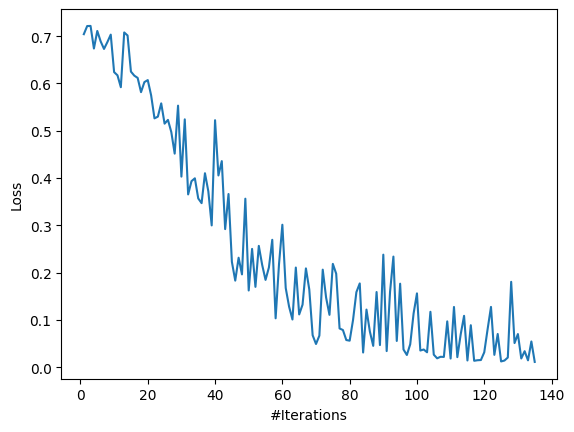

In [98]:
import matplotlib.pyplot as plt
iterations = list(range(1,len(loss)+1))
plt.plot(iterations, loss)
plt.ylabel('Loss')
plt.xlabel('#Iterations')
plt.show()

###Save the trained model for future inference

In [11]:
import os
# Save model and tokenizer
output_dir = "/content/drive/MyDrive/Parspec/"
if not os.path.exists(output_dir):
  os.mkdir(output_dir)

model_to_save = model.module if hasattr(model, 'module') else model
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

('/content/drive/MyDrive/Parspec/tokenizer_config.json',
 '/content/drive/MyDrive/Parspec/special_tokens_map.json',
 '/content/drive/MyDrive/Parspec/vocab.txt',
 '/content/drive/MyDrive/Parspec/added_tokens.json')

###Check our trained model performance on test data

In [101]:
def test(model):
  """
  model: trained BERT model/loaded BERT model
  returns predictions
  """
  # Inference loop
  model.eval()
  all_preds = []
  with torch.no_grad():
      for batch in tqdm(test_dataloader, desc="Test"):
          batch = tuple(t.to(device) for t in batch)
          inputs = {'input_ids': batch[0], 'attention_mask': batch[1], 'labels': batch[2]}
          outputs = model(**inputs)
          logits = outputs.logits
          preds = torch.argmax(logits, dim=1)
          all_preds.extend(preds.cpu().numpy())
  return all_preds

# Evaluate
all_preds = test(trained_model)
accuracy = accuracy_score(list(y_test), all_preds)
print(f"Test Accuracy: {accuracy}")

Test: 100%|██████████| 3/3 [00:00<00:00,  5.35it/s]

Test Accuracy: 0.7375
